# Dual Loop Model for Population Control

Cindy Ren 03/12/2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import math
import scipy
import numpy as np
import seaborn as sns
sns.set_context("talk", font_scale=1.3, rc={"lines.linewidth": 3.0})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

In [2]:
def f(x, n, k):
    """
    Hill-like activation
    
    n: Hill coefficient
    k: threshold
    """
    return x**n / (k**n + x**n)

### Parameters

$k_{C_1}=0.05$: $C_1$ growth rate

$k_{C_2}=0.05$: $C_2$ growth rate

$c_{\max}=10^9$: carrying capacity

$d_{C_1}=0.2$: $C_1$ death rate by ccdB ($T_1$)

$d_{C_2}=0.2$: $C_2$ death rate by ccdB ($T_2$)

$D=0$: basal death rate (default=0)

$k_{T_1}=1.1$: ccdB $T_1$ production rate in $C_1$

$k_{T_2}=1.1$: ccdB $T_2$ production rate in $C_2$

$K_T=10^8$: AHL activation threshold in ccdB production

$k_{TA}^{+}=100$: ccdB-ccdA sequestration rate

$d=0.1k_d$: ccdB, ccdA dilution rate ($k_d$ is to control if this dilution is neglegible, only for simulation, defaul=1)

$g_A=1$: basal ccdA production rate

$k_{A_1}=1$: ccdA $A_1$ production rate in $C_1$

$k_{A_2}=1$: ccdA $A_2$ production rate in $C_2$

$K_A=10^8$: AHL activation threshold in ccdA production

$k_{S_1}=0.5$ : AHL $S_1$ synthesis rate

$k_{S_2}=0.5\text{ref}_{12}$: AHL $S_2$ synthesis rate (reference ref$_{12}$ is set by inducer)

$d_S=1$: AHL dilution rate


### Population Ratio Control by ccdB-ccbA

In [3]:
def death_dx_dt(x, t, params, n):
    
    C1, C2, T1, T2, A1, A2, S1, S2 = x 
    kc1,kc2, cmax, dc1,dc2,D, kT1, kT2, KT, konTA, d, gA, kA1, kA2, KA, kS1, kS2, dS= params
    beta = n
    
    
    return np.array([kc1*C1*(1-(C1+C2)/cmax)-dc1*C1*T1-D*C1,
                     kc2*C2*(1-(C2+C2)/cmax)-dc2*C2*T2-D*C2,
                     kT1*f(S1,beta,KT)-konTA*T1*A1-d*T1,
                     kT2*f(S2,beta,KT)-konTA*T2*A2-d*T2,
                     gA+kA1*f(S2,beta,KA)-konTA*T1*A1-d*A1,
                     gA+kA2*f(S1,beta,KA)-konTA*T2*A2-d*A2,
                     kS1*C1-(dS+D)*S1,
                     kS2*C2-(dS+D)*S2])

In [4]:
tt=1000
dt=0.1
t0 = np.linspace(0, tt, tt/dt)
t1 = np.linspace(tt, 2*tt, 2*tt/dt)
# Initial condiations
              # C1, C2,  T1, T2, A1, A2, S1, S2
x0 = np.array([500, 300, 0,  0,  0,  0,  0,  0])

kd =1
r12=1 #Ratio reference set by inducer level 

                   #kc1,  kc2,   cmax,  dc1,  dc2,  D,  kT1,  kT2,  KT,    konTA,   d,         gA,   kA1, kA2, KA         
params = np.array([0.05, 0.05, 10**9,  0.2, 0.2,   0,   1.1,  1.1,  10**8,  100,   0.1*kd,   0.2,  1,   1,  10**8, 
                  #kS1,  kS2,     dS
                   0.5,  0.5*r12,  1])
n = 2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


Text(0.5,1,'Population Ratio Control w/ \nPerturbation on $C_1$ Growth')

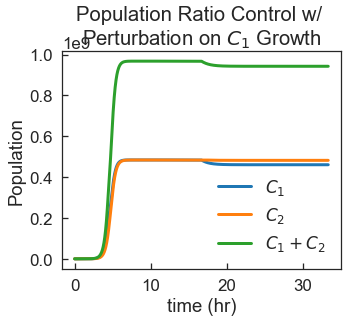

In [5]:
# Choose parameters
y0 = scipy.integrate.odeint(death_dx_dt, x0, t0, (params, n))
params1=np.copy(params)
params1[0]=params[0]*0.5 # Perturbaton on C1 growth rate
y1 = scipy.integrate.odeint(death_dx_dt, y0[-1,:], t1, (params1, n))
t=np.concatenate((t0,t1), axis=0)
y=np.concatenate((y0,y1), axis=0)
plt.figure(1,figsize=(5,4))
plt.plot(t/60, y[:,0],c=color[0],linewidth=3)
plt.plot(t/60, y[:,1],c=color[1],linewidth=3)
plt.plot(t/60, y[:,0]+y[:,1],c=color[2],linewidth=3)
plt.xlabel('time (hr)')
plt.ylabel('Population')
plt.legend(['$C_1$','$C_2$','$C_1+C_2$'],loc='best')
plt.title('Population Ratio Control w/ \nPerturbation on $C_1$ Growth')
#print(y[-1,-4:-1], y0[-1,-4:-1])

In [6]:
tt=20000
dt=1
t0 = np.linspace(0, tt, tt/dt)

per=1 #1,0.5
kd =1 #1,0.1
rt=1
r12_set=np.arange(0,10.1,0.1)

# Choose parameters
yss=np.zeros([len(r12_set),2])
for i in np.arange(len(r12_set)):
    params0=np.copy(params)
    params0[-2]=params[-2]*r12_set[i]
    y0 = scipy.integrate.odeint(death_dx_dt, x0, t0, (params0, n))
    yss[i,:]=y0[-1,0:2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Population Ratio Control \nBy Setting Inducer Reference')

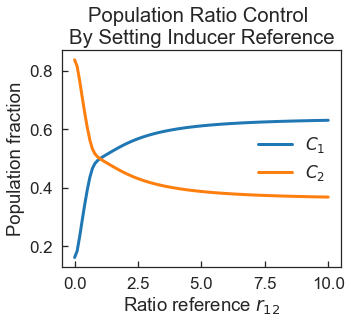

In [22]:
#np.save('ratio_population_dilution_1.npy',[yss])
[yss_1]=np.load('ratio_population_dilution_1.npy')
plt.figure(2,figsize=(5,4))
plt.plot(r12_set, yss_1[:,0]/(yss_1[:,0]+yss_1[:,1]),c=color[0],linewidth=3)
plt.plot(r12_set, yss_1[:,1]/(yss_1[:,0]+yss_1[:,1]),c=color[1],linewidth=3)
plt.xlabel('Ratio reference $r_{12}$')
plt.ylabel('Population fraction')
plt.legend(['$C_1$','$C_2$'],loc='best')
plt.title('Population Ratio Control \nBy Setting Inducer Reference')

### Parameters

$k_{G_1}=2.1$: gp2 $G_1$ production rate in $C_1$

$k_{G_2}=2.1$: gp2 $G_2$ production rate in $C_2$

$K_G=10^8$: AHL activation threshold in gp2 production

$k_{GR}^{+}=100$: gp2-RNA polymerase sequestration rate

$g_R=2$: RNA polymerase production rate

$d_r=0.5k_d$: gp2, RNA polymerase dilution rate ($k_d$ is to control if this dilution is neglegible, only for simulation, defaul=1)

$k_{Sg_1}=0.5\text{ref}_t$: AHL synthesis rate in $C_1$

$k_{Sg_2}=0.5\text{ref}_t$: AHL synthesis rate in $C_2$

### Population Capping Control by gp2

In [8]:
def growth_dx_dt(x, t, params, n):
    
    C1, C2,  G1, G2, R1, R2, Sg = x 
    kc1,kc2, cmax,D, kG1,kG2, KG, konGR, gR, dr, kSg1, kSg2, dS= params
    beta = n
    
    
    return np.array([kc1*C1*R1*(1-(C1+C2)/cmax)-D*C1,
                     kc2*C2*R2*(1-(C2+C2)/cmax)-D*C2,
                     kG1*f(Sg,beta,KG)-konGR*G1*R1-dr*G1,
                     kG2*f(Sg,beta,KG)-konGR*G2*R2-dr*G2,
                     gR-konGR*G1*R1-dr*R1,
                     gR-konGR*G2*R2-dr*R2,
                     kSg1*C1+kSg2*C2-(dS+D)*Sg])

In [17]:
tt=1000
dt=0.1
t0 = np.linspace(0, tt, tt/dt)
t1 = np.linspace(tt, 2*tt, 2*tt/dt)
# Initial condiations
              # C1, C2,  G1, G2, R1, R2, Sg
x0 = np.array([500, 300, 0,   0,  1,  1,  0])

kd =1
rt=1 #Ratio reference set by inducer level 
                   #kc1,  kc2,   cmax,   D,    kG1,   kG2,  KG,   konGR,  gR,     dr,   kSg1,      kSg2,      dS       
params = np.array([0.05, 0.05, 10**9,  0.01, 2.5,  2.5,  10**8,  100,    2,   0.5*kd,  0.5*rt,    0.5*rt,     1 ])
n = 2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


Text(0.5,1,'Population Cap Control w/\n Perturbation in $C_1$ Growth')

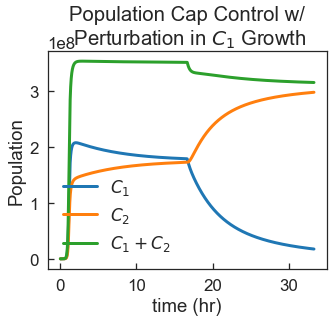

In [18]:
# Choose parameters
y0 = scipy.integrate.odeint(growth_dx_dt, x0, t0, (params, n))
params1=np.copy(params)
params1[0]=params[0]*0.5 # Perturbaton on C1 growth rate
y1 = scipy.integrate.odeint(growth_dx_dt, y0[-1,:], t1, (params1, n))
t=np.concatenate((t0,t1), axis=0)
y=np.concatenate((y0,y1), axis=0)
plt.figure(1,figsize=(5,4))
plt.plot(t/60, y[:,0],c=color[0],linewidth=3)
plt.plot(t/60, y[:,1],c=color[1],linewidth=3)
plt.plot(t/60, y[:,0]+y[:,1],c=color[2],linewidth=3)
plt.xlabel('time (hr)')
plt.ylabel('Population')
plt.legend(['$C_1$','$C_2$','$C_1+C_2$'],loc='best')
plt.title('Population Cap Control w/\n Perturbation in $C_1$ Growth')
#print(y[-1,-4:-1], y0[-1,-4:-1])

In [19]:
tt=20000
dt=1
t0 = np.linspace(0, tt, tt/dt)

per=1 #1,0.5
kd =1 #1,0.1
rt_set=np.arange(0,10.1,0.1)
                   #kc1,  kc2,   cmax,   D,    kG1,   kG2,  KG,   konGR,  gR,     dr,   kSg1,      kSg2,      dS       
params = np.array([0.05, 0.05, 10**9,  0.01, 2.5,  2.5,  10**8,  100,    2,   0.5*kd,  0.5*rt,    0.5*rt,     1 ])

yss_t=np.zeros([len(rt_set),2])
for i in np.arange(len(rt_set)):
    params0=np.copy(params)
    params0[-2]=params[-2]*rt_set[i]
    params0[-3]=params[-3]*rt_set[i]
    y0 = scipy.integrate.odeint(growth_dx_dt, x0, t0, (params0, n))
    yss_t[i,:]=y0[-1,0:2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Population Cap Control By \n Setting Inducer Reference')

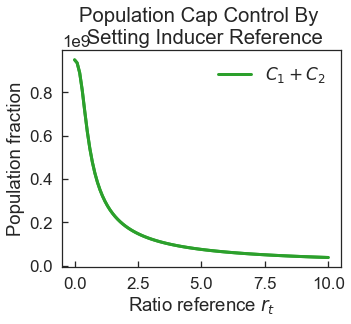

In [20]:
#np.save('cap_population_dilution_1.npy',[yss_t])
[yss_t_1]=np.load('cap_population_dilution_1.npy')
plt.figure(2,figsize=(5,4))
plt.plot(r12_set, yss_t_1[:,0]+yss_t_1[:,1],c=color[2],linewidth=3)
plt.plot(r12_set, yss_t_1[:,1]+yss_t_1[:,1],c=color[2],linewidth=3)
plt.xlabel('Ratio reference $r_{t}$')
plt.ylabel('Population fraction')
plt.legend(['$C_1+C_2$'],loc='best')
plt.title('Population Cap Control By \n Setting Inducer Reference')

### Population Capping + Ratio Control by Dual Loops

In [12]:
def dual_dx_dt(x, t, params, n):
    
    C1, C2, T1, T2, A1, A2, G1, G2, R1, R2, S1, S2, Sg = x 
    kc1,kc2, cmax, dc1,dc2,D, kT1, kT2, KT, konTA, d, gA, kA1, kA2, KA,\
    kG1,kG2, KG, konGR, gR, dr, kS1, kS2, kSg1, kSg2, dS= params
    beta = n
    
    
    return np.array([kc1*C1*R1*(1-(C1+C2)/cmax)-dc1*C1*T1-D*C1,
                     kc2*C2*R2*(1-(C2+C2)/cmax)-dc2*C2*T2-D*C2,
                     kT1*f(S1,beta,KT)-konTA*T1*A1-d*T1,
                     kT2*f(S2,beta,KT)-konTA*T2*A2-d*T2,
                     gA+kA1*f(S2,beta,KA)-konTA*T1*A1-d*A1,
                     gA+kA2*f(S1,beta,KA)-konTA*T2*A2-d*A2,
                     kG1*f(Sg,beta,KG)-konGR*G1*R1-dr*G1,
                     kG2*f(Sg,beta,KG)-konGR*G2*R2-dr*G2,
                     gR-konGR*G1*R1-dr*R1,
                     gR-konGR*G2*R2-dr*R2,
                     kS1*C1-(dS+D)*S1,
                     kS2*C2-(dS+D)*S2,
                     kSg1*C1+kSg2*C2-(dS+D)*Sg])

In [13]:
tt=1000
dt=0.1
t0 = np.linspace(0, tt, tt/dt)
t1 = np.linspace(tt, 2*tt, 2*tt/dt)
# Initial condiations
              # C1, C2,  T1, T2, A1, A2, G1, G2, R1, R2, S1, S2, Sg
x0 = np.array([500, 300, 0,  0,  0,  0,  0,   0,  1,  1,   0,  0,  0])

kd =1
r12=1 # reference
rt=1 # reference
                   #kc1,  kc2,   cmax,  dc1,  dc2,    D,    kT1,  kT2,  KT,    konTA,   d,         gA,   kA1, kA2, KA         
params = np.array([0.05, 0.05, 10**9,  0.2, 0.2,   0,   1.1,  1.1,  10**8,  100,   0.1*kd,   0.2,  1,   1,  10**8, 
                  #kG1,kG2, KG,   konGR,  gR,     dr,     kS1,  kS2,        kSg1,      kSg2,          dS
                   2.5,  2.5,  10**8,  100,    2,   0.5*kd,  0.5,  0.5*r12,   0.5*rt,    0.5*rt,     1])
n = 2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


Text(0.5,1,'Population Cap + Ratio Control \n w/ Perturbation in $C_1$ Growth')

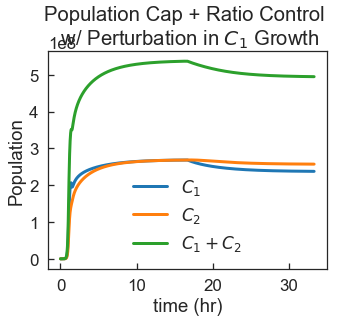

In [14]:
# Choose parameters
y0 = scipy.integrate.odeint(dual_dx_dt, x0, t0, (params, n))
params1=np.copy(params)
params1[0]=params[0]*0.5 # perturbation
y1 = scipy.integrate.odeint(dual_dx_dt, y0[-1,:], t1, (params1, n))
t=np.concatenate((t0,t1), axis=0)
y=np.concatenate((y0,y1), axis=0)
plt.figure(1,figsize=(5,4))
plt.plot(t/60, y[:,0],c=color[0],linewidth=3)
plt.plot(t/60, y[:,1],c=color[1],linewidth=3)
plt.plot(t/60, y[:,0]+y[:,1],c=color[2],linewidth=3)
plt.xlabel('time (hr)')
plt.ylabel('Population')
plt.legend(['$C_1$','$C_2$','$C_1+C_2$'],loc='best')
plt.title('Population Cap + Ratio Control \n w/ Perturbation in $C_1$ Growth')
#print(y[-1,-4:-1], y0[-1,-4:-1])

In [53]:
tt=20000
dt=1
t0 = np.linspace(0, tt, tt/dt)

per=1 #1,0.5
kd =0.1 #1,0.1
rt=1
r12_set=np.arange(0,10.1,0.1)
                   #kc1,  kc2,   cmax,  dc1,  dc2,    D,    kT1,  kT2,  KT,    konTA,   d,         gA,   kA1, kA2, KA         
params = np.array([0.05*per, 0.05, 10**9,  0.2, 0.2,   0,   1.1,  1.1,  10**8,  100,   0.1*kd,   0.2,  1,   1,  10**8, 
                  #kG1,kG2, KG,   konGR,  gR,     dr,     kS1,  kS2,        kSg1,      kSg2,          dS
                   2.5,  2.5,  10**8,  100,    2,   0.5*kd,  0.5,  0.5*r12,   0.5*rt,    0.5*rt,     1])
# Choose parameters
yss=np.zeros([len(r12_set),2])
for i in np.arange(len(r12_set)):
    params0=np.copy(params)
    params0[-4]=params[-4]*r12_set[i]
    y0 = scipy.integrate.odeint(dual_dx_dt, x0, t0, (params0, n))
    yss[i,:]=y0[-1,0:2]

r12=1
rt_set=np.arange(0,10.1,0.1)
                  #kc1,  kc2,   cmax,  dc1,  dc2,    D,    kT1,  kT2,  KT,    konTA,   d,         gA,   kA1, kA2, KA         
params = np.array([0.05*per, 0.05, 10**9,  0.2, 0.2,   0,   1.1,  1.1,  10**8,  100,   0.1*kd,   0.2,  1,   1,  10**8, 
                  #kG1,kG2, KG,   konGR,  gR,     dr,     kS1,  kS2,        kSg1,      kSg2,          dS
                   2.5,  2.5,  10**8,  100,    2,   0.5*kd,  0.5,  0.5*r12,   0.5*rt,    0.5*rt,     1])
yss_t=np.zeros([len(rt_set),2])

for i in np.arange(len(rt_set)):
    params0=np.copy(params)
    params0[-2]=params[-2]*rt_set[i]
    params0[-3]=params[-3]*rt_set[i]
    y0 = scipy.integrate.odeint(dual_dx_dt, x0, t0, (params0, n))
    yss_t[i,:]=y0[-1,0:2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Total population size')

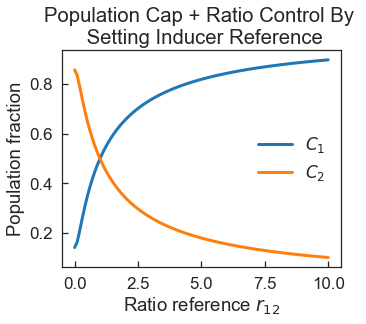

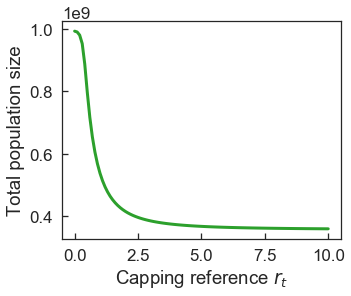

In [25]:
#np.save('dual_population_dilution_1_p05.npy',[yss,yss_t])
[yss_1,yss_t_1]=np.load('dual_population_dilution_1.npy')
plt.figure(2,figsize=(5,4))
plt.plot(r12_set, yss_1[:,0]/(yss_1[:,0]+yss_1[:,1]),c=color[0],linewidth=3)
plt.plot(r12_set, yss_1[:,1]/(yss_1[:,0]+yss_1[:,1]),c=color[1],linewidth=3)
plt.xlabel('Ratio reference $r_{12}$')
plt.ylabel('Population fraction')
plt.legend(['$C_1$','$C_2$'],loc='best')
plt.title('Population Cap + Ratio Control By \n Setting Inducer Reference')

plt.figure(3,figsize=(5,4))
plt.plot(rt_set, yss_t_1[:,0]+yss_t_1[:,1],c=color[2],linewidth=3)
plt.xlabel('Capping reference $r_{t}$')
plt.ylabel('Total population size')